# Bach Figured bass analysis

## Done
- Got a countvectorized representation

## TO DO:
- The countvectorized_data includes only n-grams of figuration. Next, combine figuration and bass movement counted in half-step (e.g. +2, -1, etc...)
    - When I create the string I can a word in between figure bass to describe the bass motion. Then I would copute the n-grams only for odd numbers. e.g. RO would be: !6! [+2] !6 5!
    - the ! are rather ugly, better use [] and {}

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import seaborn as sns

In [2]:
def import_and_clean(filename):
    part_types = pd.read_csv(filename, 
                     skiprows=3, sep='\t',nrows=0)
    df = pd.read_csv(filename, 
                     skiprows=13, names=['fb'],
                     sep='\t', usecols = np.argwhere(part_types.columns=='**fb').flatten(),
                     )
    # Drop rows corresponding to bar number or where the harmony doesn't change
    df.drop(index=np.argwhere(df.loc[:,'fb'].str.contains('=').values).flatten(),inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.drop(index=df.index[-2:], inplace=True)
    df.drop(index=np.argwhere(df.loc[:,'fb'].str.contains('\\.').values).flatten(),inplace=True)
    df.reset_index(inplace=True,drop=True)

    # convert to a string
    A = list(df['fb'].values)
    string = ''
    for i, s in enumerate(A):
        if i>0:
            string += ' '
        string += f"[{s}]"
    return string

In [3]:
basefolder = "../Data/Music/Figured_bass/Bach_chorale_FB-master/FB_source/translated_kern/"
string_dict = {}
for file in listdir(basefolder):
    if file[-4:] == '.krn':
        string_dict[file[:-15]] = import_and_clean(basefolder + file)

df = pd.DataFrame.from_dict(string_dict,orient='index',columns=['fb'])
df.head()

,fb
BWV_13.06_,[6] [6] [6] [6 5] [6] [7] [nr6] [5] [5_] [5] [...
BWV_174.05_,[5] [6] [6] [5] [6 5] [4] [3] [9] [6] [5] [#6\...
BWV_251_,[6] [6] [7] [5] [6] [nr6] [6 nr5] [4] [3] [6] ...
BWV_244.32_,[5] [6] [5] [6] [6] [4] [3] [6 4 2] [6 4 2] [6...
BWV_248.42_,[6]


# TfIdf

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(token_pattern=r"\[[^\[\]]+\]")
vectorized_data = vectorizer.fit_transform(df['fb'])

print(vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names(),index=df.index)

tfidf_df.head()

['[ ]', '[# 7]', '[#2\\]', '[#2| 4]', '[#2|]', '[#4| 2]', '[#4| 6]', '[#4|]', '[#5\\ #]', '[#5\\ 4]', '[#5\\]', '[#5| #]', '[#5| 4 9]', '[#5| 4]', '[#5| 9 3]', '[#5|]', '[#6\\ #4| 2]', '[#6\\ #4| 3]', '[#6\\ -r5]', '[#6\\ 4 3]', '[#6\\ 4]', '[#6\\ 5]', '[#6\\ n]', '[#6\\ nr5]', '[#6\\]', '[#7\\ 2]', '[#7\\ 4 2]', '[#7\\ 4]', '[#7\\ 5]', '[#7\\]', '[#7| 5 4]', '[#7| 7]', '[#7|]', '[#]', '[#_]', '[#r5]', '[#r6 #4| 2]', '[#r6 5]', '[#r7]', '[*]', '[-]', '[-r4]', '[-r5]', '[-r6 4 -r2]', '[-r6 4 2]', '[-r6 4]', '[-r6]', '[-r7 3]', '[-r7 5]', '[-r7]', '[2 #4| 6]', '[2 -5/]', '[2 4]', '[2 nr4 6]', '[2]', '[3 5 7]', '[3 5]', '[3 6 #4|]', '[3 6]', '[3 7]', '[3 8]', '[3]', '[4 #2\\]', '[4 #2|]', '[4 #5| 9]', '[4 #7| 5]', '[4 2 5]', '[4 2]', '[4 5 2]', '[4 5]', '[4 6 2]', '[4 6 8]', '[4 6]', '[4 7]', '[4 9 #7\\]', '[4 9]', '[4]', '[5 #2|]', '[5 #6\\]', '[5 #]', '[5 -]', '[5 -r4 2]', '[5 2]', '[5 3 7]', '[5 3]', '[5 4 #2|]', '[5 4 -r2]', '[5 4 2]', '[5 4]', '[5 6]', '[5 7]', '[5 8]', '[5 ]', '[5 n

,[ ],[# 7],[#2\],[#2| 4],[#2|],[#4| 2],[#4| 6],[#4|],[#5\ #],[#5\ 4],...,[nr5],[nr6 #4| 3],[nr6 4 2],[nr6 4 3],[nr6 5],[nr6],[nr7 #],[nr7 4 2],[nr7 5],[nr7]
BWV_13.06_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.148579,0.0,0.0,0.0,0.0
BWV_174.05_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.099416,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
BWV_251_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.115714,0.0,0.0,0.0,0.0
BWV_244.32_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.134735,0.0,0.0,0.0,0.0
BWV_248.42_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


# Generate n-grams

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r"\[[^\[]+\]",                              
                             ngram_range=(2,2),
                            min_df=10)
vectorized_data = vectorizer.fit_transform(df['fb'])
countvec_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names(),
                           index=df.index)
countvec_df.head()

,[#6\] [#],[#6\] [6],[#] [#],[#] [5],[#] [6 5],[#] [6],[#] [7],[3] [6 5],[3] [6],[4] [#],...,[7] [5],[7] [6 5],[7] [6],[7] [7],[8 #] [7],[8] [6 5],[8] [7],[9] [6],[9] [8],[n] [6]
BWV_13.06_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
BWV_174.05_,1,0,0,1,0,2,0,0,0,0,...,2,0,2,0,0,0,1,1,0,0
BWV_251_,0,0,0,0,0,2,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
BWV_244.32_,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
BWV_248.42_,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


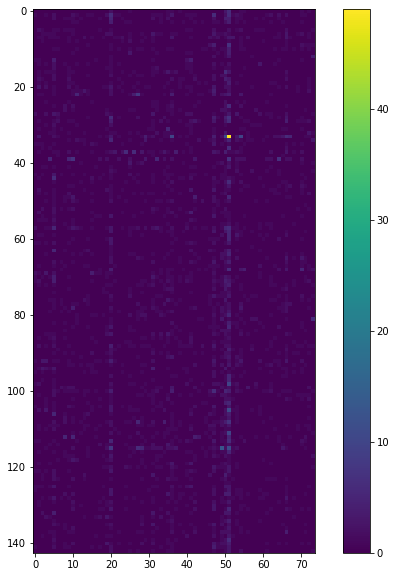

In [11]:
fig = plt.figure(figsize=[10,10])
plt.imshow(countvec_df)
plt.colorbar()

# Find the most common n-grams

<AxesSubplot:xlabel='0', ylabel='index'>

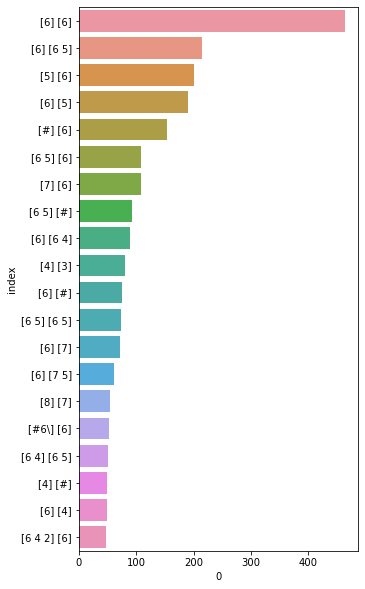

In [15]:
figure = plt.figure(figsize=[5,10])
temp = countvec_df.sum(axis=0).sort_values(ascending=False)[:20].reset_index()
temp
sns.barplot(data=temp,y='index',x=0)